# Intro
Recommender systems are all over the place, assisting you in your search for everything from books to romantic dates, hotels to restaurants.

There are several recommender systems for various scenarios, depending on your needs and accessible data.
In our situation, the purpose is to build a recommender system using implicit data , which is clickstream ecommerce multicategory store.

## Data 

Each row in the file represents an event. All events are related to products and users. Each event is like many-to-many relation between products and users.


<table>
<thead>
<tr>
<th>Property</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td><strong>event_time</strong></td>
<td>Time when event happened at (in UTC).</td>
</tr>
<tr>
<td><strong>event_type</strong></td>
<td>Three kinds of events: view, cart and purchase.</td>
</tr>
<tr>
<td><strong>product_id</strong></td>
<td>ID of a product</td>
</tr>
<tr>
<td><strong>category_id</strong></td>
<td>Product's category ID</td>
</tr>
<tr>
<td><strong>category_code</strong></td>
<td>Product's category taxonomy (code name) if it was possible to make it. Usually present for meaningful categories and skipped for different kinds of accessories.</td>
</tr>
<tr>
<td><strong>brand</strong></td>
<td>Downcased string of brand name. Can be missed.</td>
</tr>
<tr>
<td><strong>price</strong></td>
<td>Float price of a product. Present.</td>
</tr>
<tr>
<td><strong>user_id</strong></td>
<td>Permanent user ID.</td>
</tr>
<tr>
<td>** user_session**</td>
<td>Temporary user's session ID. Same for each user's session. Is changed every time user come back to online store from a long pause.</td>
</tr>
</tbody>
</table>

### Event types
The Event types are
<li><code>view</code> - a user viewed a product</li>
<li><code>cart</code> - a user added a product to shopping cart</li>
<li><code>purchase</code> - a user purchased a product</li>


### Time Frame
* The events in this dataset happend in October and November of 2019.
* The datatset is split to two CSV files , each file corresponds to a different month.

### Methodology
Due to the huge size of data, and limited amount of available resources of the kaggle kernels (16GB of RAM), the conventional methodes of reading, manipulating and anlysing data (mainly speaking about Pandas DataFrame) could not be used in the preprocessing stage due to the folowing reasons:
* Pandas provides data structures for in-memory analytics. which makes using pandas to analyze datasets that are larger than memory datasets somewhat tricky. 
* Even datasets that are a sizable fraction of memory become unwieldy, as some pandas operations need to make intermediate copies.
* Pandas lacks multiprocessing of tasks which makes complex tasks time consuming.
##### To overcome these problems, other pwerfull libraries simillar to pandas were used in the first stages of this study (mainly preprocessing), we uesed the following libraries :
* **dask_cudf** : to load multiple files in parallel at the same time, and preprocess them without loading them to GPU memory.
* **cudf** : which is simillar to pandas, but it uses GPU memory and processor to speed up to calculations.

# Reading Data 

## Importing Relevent Libraries

In [1]:
import numpy as np
import pandas as pd
import dask
import dask.dataframe as dd
import dask_cudf
import cudf
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from scipy.sparse import coo_matrix, csr_matrix
import implicit
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import CosineRecommender
from implicit.evaluation import train_test_split,mean_average_precision_at_k, ranking_metrics_at_k
from datetime import datetime
from functools import reduce
import optuna
from optuna import samplers
from IPython.display import display, HTML, display_html
sns.set()
style.use('ggplot')
%matplotlib inline 
dask.config.set(scheduler='processes')
plt.rcParams["figure.figsize"] = (8, 6)


### Reading the CSV data

In [2]:
%%time
cdf = dask_cudf.read_csv("/kaggle/input/ecommerce-behavior-data-from-multi-category-store/*.csv",
                        dtype={'event_time':'str','user_session':'int','category_id':'str','category_code': 'str', 'user_id': 'int', 'product_id':'int', 'event_type':'str', 'brand':'str', 'price':'float32' }
                       )
cdf.head()

CPU times: user 907 ms, sys: 586 ms, total: 1.49 s
Wall time: 16.5 s


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.070007,520088904,0
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.649994,530496790,8
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,<NA>,creed,28.309999,561587266,755422
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.869995,518085591,0
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.270004,558856683,0


In [3]:
cdf = cdf.drop(['event_time', 'category_id', 'user_session'], axis=1)
cdf = cdf.astype({'brand':'category'})
cdf

,event_type,product_id,category_code,brand,price,user_id
npartitions=56,,,,,,
,object,int64,object,category,float32,int64
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


These steps are carried out because :
* the dropped columns are useless to our sudy.
* more importantly to reduce the dataframe memory use.

We finally load the dataframe to GPU memory.

In [4]:
%%time
df = cdf.compute()
df

CPU times: user 24.1 s, sys: 44.5 s, total: 1min 8s
Wall time: 3min 16s


,event_type,product_id,category_code,brand,price,user_id
0,view,1003461,electronics.smartphone,xiaomi,489.070007,520088904
1,view,5000088,appliances.sewing_machine,janome,293.649994,530496790
2,view,17302664,<NA>,creed,28.309999,561587266
3,view,3601530,appliances.kitchen.washer,lg,712.869995,518085591
4,view,1004775,electronics.smartphone,xiaomi,183.270004,558856683
...,...,...,...,...,...,...
236338,view,2300275,electronics.camera.video,gopro,527.400024,537931532
236339,view,10800172,<NA>,redmond,61.750000,527322328
236340,view,5701038,auto.accessories.player,kenwood,128.699997,566280422
236341,view,21407424,electronics.clocks,tissot,689.849976,513118352


# EDA

## Missing Values

In [6]:
NULL = df.isnull().sum().to_frame().to_pandas()
NULL.columns = ['null counts']
NULL['ratio'] = NULL.iloc[:,:]/df.shape[0]
NULL.apply(lambda s: s.apply('{0:.2f}'.format))

,null counts,ratio
event_type,0.00,0.00
product_id,0.00,0.00
category_code,35413780.00,0.32
brand,15341158.00,0.14
price,0.00,0.00
user_id,0.00,0.00


Key learnings:
* 32% of category code values are not available
* 14% of brand values are not available

## Feature Analysis

,view,cart,purchase
event_type,104335509.00,3955446.00,1659788.00
ratio,0.95,0.04,0.02


CPU times: user 326 ms, sys: 109 ms, total: 436 ms
Wall time: 331 ms


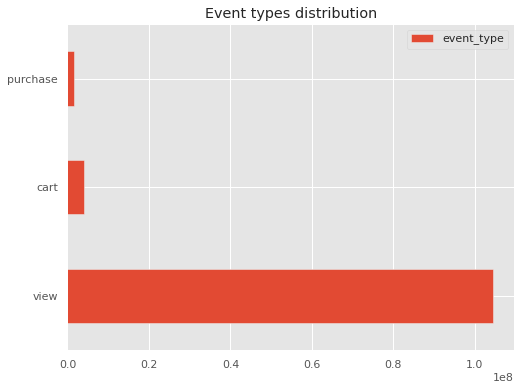

In [7]:
%%time
f, ax = plt.subplots(1,figsize=(8,6))
ET = df['event_type'].value_counts().to_pandas().to_frame()
ax = ET.plot(kind='barh',title='Event types distribution', ax=ax)
ET['ratio'] = np.round(ET['event_type'] / df.shape[0],2)
display(ET.T.apply(lambda s: s.apply('{0:.2f}'.format)).style.set_caption("Count of events by type"))

Key learnings:
* 95% of all the events are view.
* 4% of all the events are cart.
* 2% of all the events are purchase.

In [8]:
view_cart_ratio = ET['event_type'].loc['cart'] / ET['event_type'].loc['view'] *100
cart_purchase_ratio = ET['event_type'].loc['purchase'] / ET['event_type'].loc['cart']*100
view_purchase_ratio = ET['event_type'].loc['purchase'] / ET['event_type'].loc['view']*100

print('view to cart ratio : {:.2f}%. \ncart to purchase ratio: {:.2f}%. \nview to purchase ratio: {:.2f}%'.format(view_cart_ratio, cart_purchase_ratio, view_purchase_ratio))

view to cart ratio : 3.79%. 
cart to purchase ratio: 41.96%. 
view to purchase ratio: 1.59%


Key learnings:
* 3.79% of all the view events resulted in an add to cart.
* 41.96% of all the cart events resulted to a purchase.
* 1.59% of all the view events resulted in  a purchase.

,count,mean,std,min,25%,50%,75%,max
price,109950743.0,291.6,356.7,0.0,68.0,164.9,360.1,2574.1


Text(0.5, 1.0, 'Price distribution')

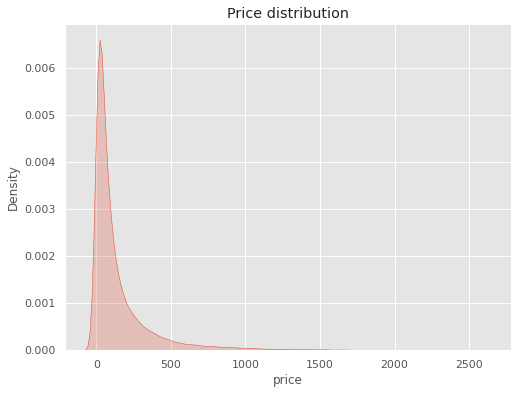

In [9]:
products = df.astype({'brand':'str'}).groupby('product_id').agg({'category_code':'first', 'brand':'first','price':'mean'})
f, ax = plt.subplots(1,figsize=(8,6))
display(df.price.describe().to_frame().to_pandas().apply(lambda s: s.apply('{0:.1f}'.format)).T.style.set_caption("Description of the price"))
sns.kdeplot(x=products['price'].to_pandas(), ax=ax,fill=True)
ax.set_title('Price distribution')

Key learnings:
* The mean price of all the products is 291, and the Standard deviation is 356, which means that there is a high variation in the prices.
* The min price of all the products is 0, this is absurd but it could mean that there are giveaways.
* 75% of the products have prices bellow 360,this means that the store specialises in middle class products.
* The max price of all the products is 2574.



,electronics.smartphone,electronics.clocks,electronics.video.tv,computers.notebook,electronics.audio.headphone,apparel.shoes,appliances.environment.vacuum,appliances.kitchen.refrigerators,appliances.kitchen.washer,computers.desktop
category_code,27882231.00,3397999.00,3321796.00,3318177.00,2917065.00,2650791.00,2329728.00,2314917.00,2273270.00,1114744.00
ratio,0.25,0.03,0.03,0.03,0.03,0.02,0.02,0.02,0.02,0.01


CPU times: user 193 ms, sys: 47.8 ms, total: 241 ms
Wall time: 222 ms


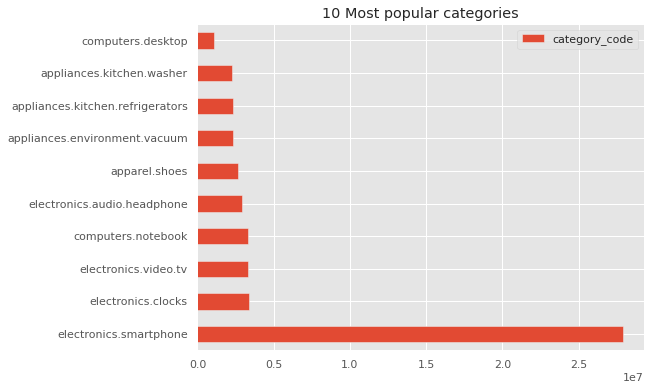

In [10]:
%%time
f, ax = plt.subplots(1,figsize=(8,6))
CC = df.category_code.value_counts().to_pandas().to_frame()
CC.head(10).plot(kind='barh', ax=ax, title='10 Most popular categories')
CC['ratio'] = np.round(CC['category_code'] / df.shape[0],2)
display(CC.head(10).T.apply(lambda s: s.apply('{0:.2f}'.format)).style.set_caption('10 Most popular categories by ratio'))

Key learnings:
* electronics.smartphone category is the most dominant category in the store by a large margin with 25% of all the events.
* The electronics category dominates the top 3 categories in the store, this means that it’s the store’s most popular category.

,electronics.clocks,electronics.audio.headphone,computers.notebook,electronics.smartphone,electronics.video.tv
category_code,8797,2377,1624,1364,640


Text(0.5, 0.98, 'Price variation of the Top 5 Categories')

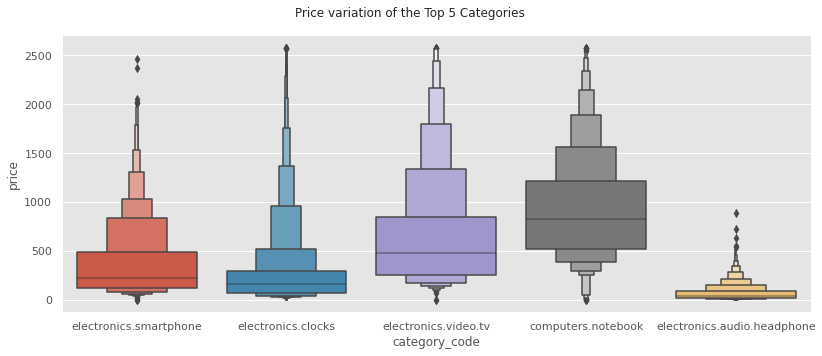

In [11]:
top_categories = CC.head(5).index.values.tolist()
top5 = products.loc[products.category_code.isin(top_categories)].to_pandas()
display(top5.category_code.value_counts().to_frame().T.style.set_caption("Number of items per category"))
g = sns.catplot(data =top5, x='category_code',y='price',kind="boxen", aspect=2.3, order=top_categories)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Price variation of the Top 5 Categories')



Key learnings:
* The mean prices of the categories are different.
* computers.notebook and electronics.video.tv are the most expensive categories in the top 5 categories.

,samsung,apple,xiaomi,huawei,lucente,lg,bosch,oppo,sony,acer
brand,13172020.00,10381933.00,7721825.00,2521331.00,1840936.00,1659394.00,1532149.00,1294585.00,1255101.00,1127129.00
ratio,0.12,0.09,0.07,0.02,0.02,0.02,0.01,0.01,0.01,0.01


CPU times: user 136 ms, sys: 44.9 ms, total: 181 ms
Wall time: 144 ms


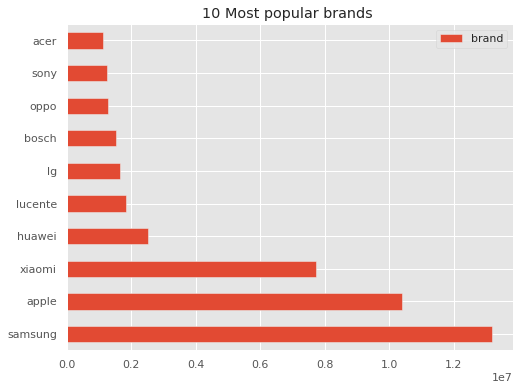

In [12]:
%%time
f, ax = plt.subplots(1,figsize=(8,6))
B = df.brand.value_counts().to_pandas().to_frame()
B.head(10).plot(kind='barh', ax=ax , title='10 Most popular brands ')
B['ratio'] = np.round(B['brand'] / df.shape[0],2)
display(B.head(10).T.apply(lambda s: s.apply('{0:.2f}'.format)).style.set_caption('10 Most popular brands by ratio') )

Key learnings:
* the top 6 brands are brands known for smartphones.
* Samsung is the in the top by 12% of all the total events, followed by Apple with 9% and Xiaomi 7%.

,bosch,samsung,xiaomi,lucente,sony,apple,lg,acer,huawei,oppo
brand,1298,1227,1054,1036,925,649,495,347,136,43


Text(0.5, 0.98, 'Price variation of the Top 10 brands')

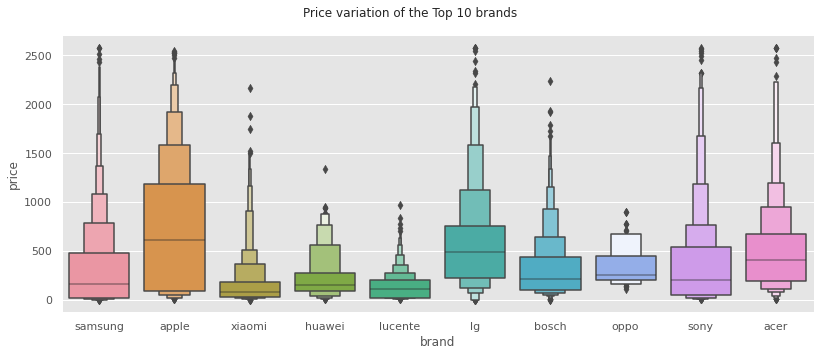

In [13]:
top_brands = B.head(10).index.values.tolist()
top10 = products.loc[products.brand.isin(top_brands)].to_pandas()
display(top10.brand.value_counts().to_frame().T.style.set_caption("Number of items per brand"))
g = sns.catplot(data =top10, x='brand',y='price',kind="boxen", aspect=2.3, order=top_brands)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Price variation of the Top 10 brands')

Key learnings:
* The distribution of prices differs between the brands.
* Apple is the most expensive brand with a lot of variation in the prices.

## Users / Products Analysis

In [14]:
%%time
#summerizing the events
event_count = df.groupby('user_id')['product_id'].count().reset_index(drop=True).to_pandas().to_frame()
event_count = event_count.describe().apply(lambda s: s.apply('{0:.1f}'.format))
event_count.rename({'product_id':'All events' }, axis=1, inplace=True)
event_count.reset_index(inplace=True)

#summerizing the view event
view_count = df.loc[df.event_type == 'view'].groupby('user_id')['product_id'].count().reset_index(drop=True).to_pandas().to_frame()
view_count = view_count.describe().apply(lambda s: s.apply('{0:.1f}'.format))
view_count.rename({'product_id':'Views' }, axis=1, inplace=True)
view_count.reset_index(inplace=True)

#summerizing the cart event
cart_count = df.loc[df.event_type == 'cart'].groupby('user_id')['product_id'].count().reset_index(drop=True).to_pandas().to_frame()
cart_count = cart_count.describe().apply(lambda s: s.apply('{0:.1f}'.format))
cart_count.rename({'product_id':'Cart' }, axis=1, inplace=True)
cart_count.reset_index(inplace=True)

#summerizing the purchase event
purchase_count = df.loc[df.event_type == 'purchase'].groupby('user_id')['product_id'].count().reset_index(drop=True).to_pandas().to_frame()
purchase_count = purchase_count.describe().apply(lambda s: s.apply('{0:.1f}'.format))
purchase_count.rename({'product_id':'Purchases' }, axis=1, inplace=True)
purchase_count.reset_index(inplace=True)

#merging all the DFs 
dfs = [event_count,view_count, cart_count, purchase_count]
users_describe = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)
users_describe.set_index('index', inplace=True)


CPU times: user 903 ms, sys: 288 ms, total: 1.19 s
Wall time: 1.2 s


In [15]:
%%time
#summerizing the events
event_count = df.groupby('product_id')['user_id'].count().reset_index(drop=True).to_pandas().to_frame()
event_count = event_count.describe().apply(lambda s: s.apply('{0:.1f}'.format))
event_count.rename({'user_id':'All events' }, axis=1, inplace=True)
event_count.reset_index(inplace=True)

#summerizing the view event
view_count = df.loc[df.event_type == 'view'].groupby('product_id')['user_id'].count().reset_index(drop=True).to_pandas().to_frame()
view_count = view_count.describe().apply(lambda s: s.apply('{0:.1f}'.format))
view_count.rename({'user_id':'Views' }, axis=1, inplace=True)
view_count.reset_index(inplace=True)

#summerizing the cart event
cart_count = df.loc[df.event_type == 'cart'].groupby('product_id')['user_id'].count().reset_index(drop=True).to_pandas().to_frame()
cart_count = cart_count.describe().apply(lambda s: s.apply('{0:.1f}'.format))
cart_count.rename({'user_id':'Cart' }, axis=1, inplace=True)
cart_count.reset_index(inplace=True)

#summerizing the purchase event
purchase_count = df.loc[df.event_type == 'purchase'].groupby('product_id')['user_id'].count().reset_index(drop=True).to_pandas().to_frame()
purchase_count = purchase_count.describe().apply(lambda s: s.apply('{0:.1f}'.format))
purchase_count.rename({'user_id':'Purchases' }, axis=1, inplace=True)
purchase_count.reset_index(inplace=True)

#merging all the DFs 
dfs = [event_count,view_count, cart_count, purchase_count]
items_describe = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)
items_describe.set_index('index', inplace=True)


CPU times: user 567 ms, sys: 321 ms, total: 888 ms
Wall time: 887 ms


In [16]:
users_styler = users_describe.style.set_table_attributes("style='display:inline'")
items_styler = items_describe.style.set_table_attributes("style='display:inline'")
display(HTML('<h2>Users Descriptive Statistics'+'\xa0'*22+' Products Descriptive Statistics</h2>'))
display_html(users_styler._repr_html_()+"\xa0" * 30 +items_styler._repr_html_(), raw=True)

,All events,Views,Cart,Purchases
index,,,,
count,5316649.0,5316128.0,1054133.0,697470.0
mean,20.7,19.6,3.8,2.4
std,53.9,52.1,6.1,4.4
min,1.0,1.0,1.0,1.0
25%,2.0,2.0,1.0,1.0
50%,5.0,5.0,2.0,1.0
75%,18.0,17.0,4.0,2.0
max,22929.0,22926.0,720.0,640.0
,All events,Views,Cart,Purchases


Key learnings:
1. **Users:**
* There are more than 5 million users in the dataset, 697 thousand of them have made at least one purchase, which is 13% of the users.
* The mean number of events per user is 21 events, but the std being 54 events means that there is a large variability between users’s activity.
* The user with the maximum number of events has 22 929 event, with the maximum number of purchases being 640 item.
2. **Products:**
* there are more than 200 thousand unique items, 68 thousand of them have been purchased at least 1 time, which is 32% of all the items.
* The mean number of purchases per item is 24 purchases, however, the std is 436 which means that there is a very large variability in the popularity of the items.
* The 75 percentile indicates that 75% of the items have 7 or less purchases, that means that the revenue of the store is generated by a small portion of popular items.
* The maximum number of purchases for a single item is more than 61 thousand purchase.

# Preprocessing

## Converting implicit events
Transforming signals from several forms of user behavior into a single rating is domain specific, after careful consideration and reviewing the literature, we chose to assign a certain weight to every event according to its importance as follows:
* **View:** has a weight of 1.
* **Cart:** has a weight of 2.
* **Purchase:** has a weight of 3.

In [17]:
%%time
#f_temp = df.to_pandas()
event_type_strength = {
    'view': 1,
    'cart': 2,
    'purchase': 3
}
df['event_type'] = df['event_type'].map(event_type_strength)
df = df.astype({'brand':'str'})
df.head(10)

CPU times: user 428 ms, sys: 209 ms, total: 637 ms
Wall time: 702 ms


,event_type,product_id,category_code,brand,price,user_id
0,1,1003461,electronics.smartphone,xiaomi,489.070007,520088904
1,1,5000088,appliances.sewing_machine,janome,293.649994,530496790
2,1,17302664,<NA>,creed,28.309999,561587266
3,1,3601530,appliances.kitchen.washer,lg,712.869995,518085591
4,1,1004775,electronics.smartphone,xiaomi,183.270004,558856683
5,1,1306894,computers.notebook,hp,360.089996,520772685
6,1,1306421,computers.notebook,hp,514.559998,514028527
7,1,15900065,<NA>,rondell,30.859999,518574284
8,1,12708937,<NA>,michelin,72.719994,532364121
9,1,1004258,electronics.smartphone,apple,732.070007,532647354


## Grouping data by User / Item
The next step is to transform the events table into the sum of events for every user and item. 
<br> The data will have every interaction of a user with an item, and assign an event strength to this interaction by summing the event_type values defined earlier.

In [18]:
%%time
#df.drop_duplicates(inplace=True)
grouped = df.groupby(['user_id', 'product_id']).agg({'event_type': 'sum',
                                                     'category_code':'first',
                                                     'brand':'first', 
                                                     'price':'first'}).reset_index()
grouped.rename({'event_type' : 'event_strength'}, axis=1, inplace=True)
grouped = grouped.astype({'price':'float32', 'event_strength':'int16'})
grouped

CPU times: user 1.86 s, sys: 202 ms, total: 2.06 s
Wall time: 2.09 s


,user_id,product_id,event_strength,category_code,brand,price
0,10300217,26300219,1,<NA>,sokolov,40.540001
1,29515875,1801638,3,electronics.video.tv,harper,153.670013
2,29515875,1802034,2,electronics.video.tv,kivi,115.040001
3,29515875,13200026,1,furniture.bedroom.bed,sv,100.360001
4,29515875,13200917,4,furniture.bedroom.bed,<NA>,514.809998
...,...,...,...,...,...,...
56371585,579969605,30200000,1,<NA>,<NA>,167.289993
56371586,579969658,21403472,1,electronics.clocks,<NA>,149.300003
56371587,579969711,2600400,3,<NA>,<NA>,208.470001
56371588,579969767,4804718,1,electronics.audio.headphone,apple,329.140015


We finaly convert the grouped data into a pandas dataframe for some particular matrix transformations.

In [19]:
%%time
grouped_df = grouped.to_pandas()
grouped_df

CPU times: user 4.36 s, sys: 2 s, total: 6.36 s
Wall time: 6.21 s


,user_id,product_id,event_strength,category_code,brand,price
0,10300217,26300219,1,None,sokolov,40.540001
1,29515875,1801638,3,electronics.video.tv,harper,153.670013
2,29515875,1802034,2,electronics.video.tv,kivi,115.040001
3,29515875,13200026,1,furniture.bedroom.bed,sv,100.360001
4,29515875,13200917,4,furniture.bedroom.bed,None,514.809998
...,...,...,...,...,...,...
56371585,579969605,30200000,1,None,None,167.289993
56371586,579969658,21403472,1,electronics.clocks,None,149.300003
56371587,579969711,2600400,3,None,None,208.470001
56371588,579969767,4804718,1,electronics.audio.headphone,apple,329.140015


## Sampling data for validation

Due to the very large number of users and items, the validation of the model may take a very long time because the metrics used for validation are not very efficient on large datasets and may take a very long time to complete.
<br>We therefore chose to sample 50,000 user from the dataset and validate the model on this sample.

### Sampling 50,000 random user

In [21]:
user_ids = df.groupby('user_id')['product_id'].count().reset_index().query('product_id > 9').user_id.unique().values.get()
users_sample = np.random.choice(user_ids, size=50000,replace=False)

### Creation of user/item and item/user sparse matrices

We create the sparse matrices from the sampled dataframe

In [24]:
%%time

grouped_sample = grouped_df.query("user_id in @users_sample")

grouped_sample['user_id'] = grouped_sample.user_id.astype('category')
grouped_sample['product_id'] = grouped_sample.product_id.astype('category')

grouped_sample['UserID'] = grouped_sample['user_id'].cat.codes
grouped_sample['ProductID'] = grouped_sample['product_id'].cat.codes

sparse_item_user_sample = csr_matrix((grouped_sample['event_strength'].astype(float), (grouped_sample['ProductID'], grouped_sample['UserID'] )))
sparse_user_item_sample = csr_matrix((grouped_sample['event_strength'].astype(float), ( grouped_sample['UserID'],grouped_sample['ProductID'] )))


CPU times: user 1.15 s, sys: 292 ms, total: 1.45 s
Wall time: 1.43 s


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [25]:
print('The total number of products: {:,}'.format(sparse_item_user_sample.shape[0]))
print('The total number of users: {:,}'.format(sparse_item_user_sample.shape[1]))

The total number of products: 112,432
The total number of users: 50,000


The sampled data has 50,000 user and more than 110,000 product.

### Splitting data into train / validation sets

In [32]:
train, val = train_test_split(sparse_item_user_sample)

In [33]:
train.shape

(112432, 50000)

# Model Selection

## Baseling Recommender: Nearest Neighbors 

We'll fit a basic Cosine Recommender as a baseline and evaluate it using 4 metrics:
* **P@k:** which stands for Precision at k
* **MAP@k:** which stands for Mean Average Precision at k
* **NDCG@k:** which stands for Normalized Discounted Cumulative Gain at k
* **AUC@k:** which stands for Area Under the Curve at k


In [34]:

CR = CosineRecommender()
CR.fit(train, show_progress=False)
metrics = ranking_metrics_at_k(CR, train.T.tocsr(), val.T.tocsr(), K=5,show_progress=True, num_threads=0)
for k,v in metrics.items():
    print('{}: {:.4f}'.format(k,v))

  0%|          | 0/50000 [00:00<?, ?it/s]

precision: 0.0257
map: 0.0168
ndcg: 0.0263
auc: 0.5133


We use the **NDCG@5 (Normalized Discounted Cumulative Gain at 5)** as the primary evaluaion metric to tune the models.
<br> It is a measure of ranking quality that is often used to measure effectiveness of web search engine algorithms or related applications.
<br> A very good explanation of NDCG@k and other evaluation metrics is given in [Ranking Metrics](http://ethen8181.github.io/machine-learning/recsys/2_implicit.html#NDCG) and [Normalized Cumulative Gain](http://https://towardsdatascience.com/normalized-discounted-cumulative-gain-37e6f75090e9).

In [35]:
# rough optimization of the NN model
N_TRIALS = 10
K = 5


def optimize_nn(trial):
    neighbors = trial.suggest_int("K", 5, 100, 5)
    nn = CosineRecommender(K=neighbors)
    nn.fit(train,show_progress=False)
    metrics = ranking_metrics_at_k(
        nn, train.T, val.T, K=K, show_progress=False
    )
    return metrics['ndcg']


sampler = samplers.TPESampler(seed=23)
nn_study = optuna.create_study(
    direction="maximize", study_name="nearest_neighbors_study"
)
nn_study.optimize(optimize_nn, n_trials=N_TRIALS, n_jobs=1, show_progress_bar=True)

[I 2022-12-16 21:14:19,177] A new study created in memory with name: nearest_neighbors_study
/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-12-16 21:14:22,473] Trial 0 finished with value: 0.0364112493028933 and parameters: {'K': 75}. Best is trial 0 with value: 0.0364112493028933.
[I 2022-12-16 21:14:26,252] Trial 1 finished with value: 0.0364112493028933 and parameters: {'K': 75}. Best is trial 0 with value: 0.0364112493028933.
[I 2022-12-16 21:14:29,838] Trial 2 finished with value: 0.037918932577866014 and parameters: {'K': 90}. Best is trial 2 with value: 0.037918932577866014.
[I 2022-12-16 21:14:32,550] Trial 3 finished with value: 0.03403774796616222 and parameters: {'K': 55}. Best is trial 2 with value: 0.037918932577866014.
[I 2022-12-16 21:14:36,527] Trial 4 finished with value: 0.038875541345622155 and parameters: {'K': 100}. Best is trial 4 with value: 0.038875541345622155.
[I 2022-12-16 21:14:40,105] Trial 5 finished with value: 0.037918932577866014 and parameters: {'K': 90}. Best is trial 4 with value: 0.038875541345622155.
[I 2022-12-16 21:14:42,035] Trial 6 finished with value: 0.027663428187890363 

In [36]:
print(f"NDCG@5 for our best Cosine model: {nn_study.best_trial.value:.3f}, The previous value is :{metrics['ndcg']:.3f}")
print(f"We achieved a rise of {((nn_study.best_trial.value - metrics['ndcg']) / metrics['ndcg'])*100:.1f}% ")


NDCG@5 for our best Cosine model: 0.039, The previous value is :0.026
We achieved a rise of 47.9% 


In [37]:
CR = CosineRecommender(K=nn_study.best_trial.params['K'])
CR.fit(train, show_progress=False)
metrics2 = ranking_metrics_at_k(CR, train.T.tocsr(), val.T.tocsr(), K=5,show_progress=True, num_threads=0)
progress = [pd.DataFrame(list(metrics.items()),columns = ['Metric','Before Tuning']),
            pd.DataFrame(list(metrics2.items()),columns = ['Metric','After Tuning'])]
progress = reduce(lambda left,right: pd.merge(left,right,on='Metric'), progress)
progress.set_index('Metric', inplace=True)
progress['Change %'] = ((progress['After Tuning'] - progress['Before Tuning'] )/ progress['Before Tuning'] *100).round(2).astype(str) + '%'
display(progress)
print(f"\nNDCG@5 for our best Cosine model: {nn_study.best_trial.value:.3f}, The previous value was :{metrics['ndcg']:.3f}")
print(f"We achieved a rise of {((nn_study.best_trial.value - metrics['ndcg']) / metrics['ndcg'])*100:.1f}% ")

  0%|          | 0/50000 [00:00<?, ?it/s]

,Before Tuning,After Tuning,Change %
Metric,,,
precision,0.025656,0.038676,50.75%
map,0.016758,0.024911,48.65%
ndcg,0.026289,0.038876,47.88%
auc,0.513263,0.518583,1.04%



NDCG@5 for our best Cosine model: 0.039, The previous value was :0.026
We achieved a rise of 47.9% 


In [38]:
alpha = 40
model = AlternatingLeastSquares(factors=20,
                                regularization=0.01,
                                iterations=20,
                                random_state=23)
model.fit(alpha * train, show_progress=False)

metrics = ranking_metrics_at_k(model, alpha * train.T, alpha * val.T, K=5,show_progress=True, num_threads=0)
print('The results of ALS by the standard parameters are:\n')
for k,v in metrics.items():
    print('{}: {:.5f}'.format(k,v))

  0%|          | 0/50000 [00:00<?, ?it/s]

The results of ALS by the standard parameters are:

precision: 0.10149
map: 0.06784
ndcg: 0.10185
auc: 0.54968


In [39]:

# Optimization of the ALS MF model
K = 5
# As this is quite computationally expensive we'll just run it for a few iterations
N_TRIALS = 15


def optimize_als(trial):
    """Runs multiple "trials" with various parameters to
    determine the best hyper parameters to use

    Args:
        trial (Trial): a Trial object which does not need to be instanciated
    """
    # matrix__confidence = trial.suggest_int("matrix__confidence", 2, 100, 5)
    factors = trial.suggest_int("factors", 5, 70, 5)
    regularization = trial.suggest_loguniform(
        "regularization", 1e-4, 1
    )  # cannot start at 0
    iterations = trial.suggest_int("iterations", 10, 100, 10)
    # alpha is a scaling factor for the raw ratings matrix https://github.com/benfred/implicit/issues/199
    alpha = trial.suggest_int("alpha", 5, 100, 5)
    als = AlternatingLeastSquares(
        factors=factors,
        regularization=regularization,
        iterations=iterations,
        random_state=23,
    )
    als.fit(alpha * train, show_progress=False)
    metrics = ranking_metrics_at_k(
        als, alpha * train.T, alpha * val.T, K=K, num_threads=0,show_progress=False
    )
    return metrics['ndcg']


study = optuna.create_study(direction="maximize", study_name="als_study",
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=5,
                                                               #n_warmup_steps=5,
                                                               #interval_steps=3,
                                                              ))
study.optimize(optimize_als, n_trials=N_TRIALS, n_jobs=1, show_progress_bar=True)

[I 2022-12-16 21:22:30,174] A new study created in memory with name: als_study
/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2022-12-16 21:24:59,643] Trial 0 finished with value: 0.08669741222497311 and parameters: {'factors': 10, 'regularization': 0.9972253585814969, 'iterations': 100, 'alpha': 90}. Best is trial 0 with value: 0.08669741222497311.
[I 2022-12-16 21:28:09,995] Trial 1 finished with value: 0.10101587715619027 and parameters: {'factors': 50, 'regularization': 0.008458510195583057, 'iterations': 90, 'alpha': 95}. Best is trial 1 with value: 0.10101587715619027.
[I 2022-12-16 21:31:23,992] Trial 2 finished with value: 0.11095529266417539 and parameters: {'factors': 60, 'regularization': 0.9456423548554109, 'iterations': 100, 'alpha': 55}. Best is trial 2 with value: 0.11095529266417539.
[I 2022-12-16 21:35:46,279] Trial 3 finished with value: 0.12836367243725663 and parameters: {'factors': 65, 'regularization': 0.0007295779593075603, 'iterations': 90, 'alpha': 25}. Best is trial 3 with value: 0.12836367243725663.
[I 2022-12-16 21:38:54,850] Trial 4 finished with value: 0.10694816848195146 and 

In [42]:
best_params = study.best_params
alpha,factors,iterations,regularization = best_params['alpha'],best_params['factors'],best_params['iterations'],best_params['regularization']
als = AlternatingLeastSquares(
        factors=factors,
        regularization=regularization,
        iterations=iterations,
        random_state=23)
als.fit(alpha * train, show_progress=False)
metrics2 = ranking_metrics_at_k(als, alpha * train.T, alpha * val.T, K=K, num_threads=0,show_progress=False)
for k,v in metrics2.items():
    print('{}: {:.4f}'.format(k,v))

precision: 0.1346
map: 0.0904
ndcg: 0.1337
auc: 0.5612


In [43]:

progress_als = [pd.DataFrame(list(metrics.items()),columns = ['Metric','Before Tuning']),
                pd.DataFrame(list(metrics2.items()),columns = ['Metric','After Tuning'])]
progress_als = reduce(lambda left,right: pd.merge(left,right,on='Metric'), progress_als)
progress_als.set_index('Metric', inplace=True)
progress_als['Change %'] = ((progress_als['After Tuning'] - progress_als['Before Tuning'] )/ progress_als['Before Tuning'] *100).round(2).astype(str) + '%'
display(progress_als)
print(f"\nNDCG@5 for our best ALS model: {study.best_trial.value:.3f}, The previous value was :{metrics['ndcg']:.3f}")
print(f"We achieved a rise of {((study.best_trial.value - metrics['ndcg']) / metrics['ndcg'])*100:.1f}% ")

,Before Tuning,After Tuning,Change %
Metric,,,
precision,0.101487,0.134551,32.58%
map,0.067841,0.090366,33.2%
ndcg,0.101848,0.133680,31.25%
auc,0.549676,0.561157,2.09%



NDCG@5 for our best ALS model: 0.134, The previous value is :0.102
We achieved a rise of 31.3% 


# Fitting the Final Model

## Creation of sparse matrices

In [45]:
%%time
grouped_df['user_id'] = grouped_df.user_id.astype('category')
grouped_df['product_id'] = grouped_df.product_id.astype('category')

grouped_df['UserID'] = grouped_df['user_id'].cat.codes
grouped_df['ProductID'] = grouped_df['product_id'].cat.codes

sparse_item_user = csr_matrix((grouped_df['event_strength'].astype(float),
                                      (grouped_df['ProductID'], grouped_df['UserID'] )))
sparse_user_item = csr_matrix((grouped_df['event_strength'].astype(float),
                                      ( grouped_df['UserID'],grouped_df['ProductID'] )))

CPU times: user 2.65 s, sys: 656 ms, total: 3.31 s
Wall time: 3.31 s


### Checking the matrix sparsity

In [46]:
matrix_size = sparse_user_item.shape[0]*sparse_user_item.shape[1] # Number of possible interactions in the matrix
num_purchases = len(sparse_user_item.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
print('Sparsity : {:.2f}%'.format(sparsity))

Sparsity : 99.99%


* The sparsity of the matrix is 99.99%, this is a majo problem for the majority of recommender models.
* Fortunately, ALS deals very well with sparse data.

In [47]:
print('The total number of products: {:,}'.format(grouped_df.product_id.unique().size))
print('The total number of users: {:,}'.format(grouped_df.user_id.unique().size))

The total number of products: 206,876
The total number of users: 5,316,649


The final number of users is over 5 million whith interaction on over 200 thousand product.

train, val = train_test_split(sparse_item_user)

### Fit the model

In this step, we fit the als algorithm with the wolr dataset using the previously found best parameters

In [48]:
alpha,factors,iterations,regularization = best_params['alpha'],best_params['factors'],best_params['iterations'],best_params['regularization']

als = AlternatingLeastSquares( factors=factors, regularization=regularization, iterations=iterations, random_state=23,use_gpu=True )
als.fit(alpha * sparse_item_user, show_progress=True) 


  0%|          | 0/60 [00:00<?, ?it/s]

### Test the model

In this step, we will test the model by selecting some random users, we then check the recommendations given by the model and compair them with the history of the same user to check if the recommendations are relevant.

In [49]:
%%time
#Create a products dataframe
items = df.groupby(['product_id'])[['category_code','brand']].first().reset_index()
items


CPU times: user 379 ms, sys: 118 ms, total: 497 ms
Wall time: 550 ms


,product_id,category_code,brand
0,1000365,electronics.smartphone,sony
1,1000978,electronics.smartphone,samsung
2,1001588,electronics.smartphone,meizu
3,1001606,electronics.smartphone,apple
4,1001618,electronics.smartphone,apple
...,...,...,...
206871,100028525,<NA>,<NA>
206872,100028530,apparel.shoes,<NA>
206873,100028536,<NA>,<NA>
206874,100028537,apparel.shoes,<NA>


In [82]:
def user_recommend(model, items_df, user_id='rand',n=100, fill_na=True):
    
    #Chose a random user from the database (if selected)
    if user_id == 'rand':
        user_id = grouped_df.UserID.sample(1).values[0]

    #Search for the user's activity group them by cetegory and brand
    history = grouped_df.query('UserID == @user_id')[['product_id','event_strength','category_code','brand']]
    if fill_na:
        history.category_code = history.category_code.fillna('N/A')
        history.brand = history.brand.fillna('N/A')
    history = history.groupby(['category_code', 'brand']).agg({'event_strength':'sum'})

    #Get the recommendations of the chosen user as an array
    recommended = als.recommend(user_id, sparse_user_item, N=n)
                               
    #Create a table of the recommended items and group them by category and brand
    recomended_items = []
    for item in recommended:
        recomended_items.append(item[0])
    recommend = items.loc[recomended_items].to_pandas()
    if fill_na:
        recommend.category_code = recommend.category_code.fillna('N/A')
        recommend.brand = recommend.brand.fillna('N/A')
    recommend = recommend.groupby(['category_code', 'brand']).agg({'product_id':'count'})
    
    #Display the History of the user and the Recommendations
    history_styler = history.style.set_table_attributes("style='display:inline'")#.set_caption('User History')
    recommend_styler = recommend.style.set_table_attributes("style='display:inline'")#.set_caption('User Recommendation')
    display(HTML('<h2>User ID: '+str(user_id)+'</h2>'))
    display(HTML('<h2>User History'+'\xa0'*45+' User Recommendation</h2>'))
    display_html(history_styler._repr_html_()+"\xa0" * 30 +recommend_styler._repr_html_(), raw=True)

In [89]:
user_recommend(model=als, items_df=items, user_id='rand',n=100, fill_na=True)

event_strength 
 
 
 category_code 
 brand 
   
 
 
 
 
 N/A 
 bosch 
 1 
 
 
 broomer 
 1 
 
 
 crown 
 1 
 
 
 force 
 1 
 
 
 rastar 
 2 
 
 
 samsung 
 10 
 
 
 apparel.shoes 
 etor 
 1 
 
 
 rooman 
 1 
 
 
 construction.tools.drill 
 bosch 
 1 
 
 
 crown 
 1 
 
 
 electronics.clocks 
 samsung 
 1 
 
 
 electronics.smartphone 
 apple 
 1 
 
 
 oppo 
 1 
 
 
 samsung 
 97 
 
 
 xiaomi 
 14 
 
 
 
                              
 
 
 
   
   
 product_id 
 
 
 category_code 
 brand 
   
 
 
 
 
 N/A 
 cordiant 
 1 
 
 
 samsung 
 1 
 
 
 stels 
 1 
 
 
 xiaomi 
 4 
 
 
 electronics.clocks 
 canyon 
 1 
 
 
 jet 
 1 
 
 
 samsung 
 1 
 
 
 xiaomi 
 2 
 
 
 electronics.smartphone 
 apple 
 1 
 
 
 oneplus 
 2 
 
 
 samsung 
 65 
 
 
 xiaomi 
 20

In [87]:
user_recommend(model=als, items_df=items, user_id=2374045 ,n=100, fill_na=True)

event_strength 
 
 
 category_code 
 brand 
   
 
 
 
 
 N/A 
 N/A 
 21 
 
 
 comforser 
 1 
 
 
 appliances.environment.air_conditioner 
 samsung 
 4 
 
 
 appliances.kitchen.refrigerators 
 lg 
 15 
 
 
 samsung 
 5 
 
 
 appliances.kitchen.washer 
 samsung 
 15 
 
 
 computers.peripherals.printer 
 samsung 
 12 
 
 
 electronics.audio.headphone 
 apple 
 35 
 
 
 electronics.clocks 
 apple 
 1 
 
 
 electronics.smartphone 
 apple 
 34 
 
 
 xiaomi 
 10 
 
 
 electronics.video.tv 
 artel 
 7 
 
 
 samsung 
 9 
 
 
 
                              
 
 
 
   
   
 product_id 
 
 
 category_code 
 brand 
   
 
 
 
 
 N/A 
 N/A 
 7 
 
 
 bts 
 1 
 
 
 dauscher 
 2 
 
 
 imperial 
 3 
 
 
 lider 
 1 
 
 
 sv 
 2 
 
 
 appliances.kitchen.refrigerators 
 dauscher 
 1 
 
 
 lg 
 7 
 
 
 midea 
 1 
 
 
 samsung 
 7 
 
 
 skyworth 
 1 
 
 
 appliances.kitchen.washer 
 bosch 
 1 
 
 
 lg 
 7 
 
 
 samsung 
 18 
 
 
 computers.peripherals.printer 
 canon 
 1 
 
 
 epson 
 5 
 
 
 hp 
 1 
 
 
 electronics.audio.headphone 
 apple 
 1 
 
 
 electronics.smartphone 
 apple 
 11 
 
 
 samsung 
 1 
 
 
 xiaomi 
 13 
 
 
 electronics.video.tv 
 artel 
 2 
 
 
 haier 
 2 
 
 
 irbis 
 1 
 
 
 kivi 
 2 
 
 
 yasin 
 1